# Deep Learning Project


## Executive Summary:

This comprehensive lab exercise detailed in the document delves deeply into the exploration and application of image classification techniques using Convolutional Neural Networks (CNNs) and transfer learning. The lab began with the downloading of a large dataset from Kaggle, which contained 25,000 images of cats and dogs, prepared for image classification tasks. Initial data exploration was crucial for understanding the composition and distribution of the images, informing the subsequent preprocessing steps where images were resized and normalized to ensure consistency in input data format.

Here, developed several baseline models using variations of the VGG architecture, experimenting with different numbers of convolutional blocks to gauge their impact on the model's performance. These models were then trained and rigorously evaluated, with performance metrics such as accuracy and loss meticulously recorded for both training and validation datasets. This process provided deep insights into the relationship between model complexity, computational demands, and performance, highlighting the challenges such as model overfitting and high variability in validation accuracy. To address these, implemented dropout layers and utilized data augmentation techniques to enrich the training data without physically increasing its size.

The second part of the lab introduced transfer learning, where utilized the MobileNet V2 architecture. This pre-trained model was adapted to the task of classifying images of cats and dogs by fine-tuning its top layers, which significantly enhanced its predictive accuracy. A comparative analysis between the baseline models and the transfer learning model demonstrated substantial improvements, confirming the effectiveness of this advanced approach.

Overall, the lab's exploration into CNNs using VGG architecture variations deepened insights into model complexity's impact on performance, highlighting challenges like overfitting. Strategic use of dropout layers and data augmentation optimized training, while transfer learning with the MobileNet V2 architecture enhanced predictive accuracy for a cat and dog image classification task. This approach demonstrated the effectiveness of advanced techniques in improving model performance and generalization, showcasing the robust potential of deep learning in practical scenarios.

# Image Classification

  - Cats and Dogs dataset

**VGG Architecture:**

VGG stands for Visual Geometry Group; it is a standard deep Convolutional Neural Network (CNN) architecture with multiple layers




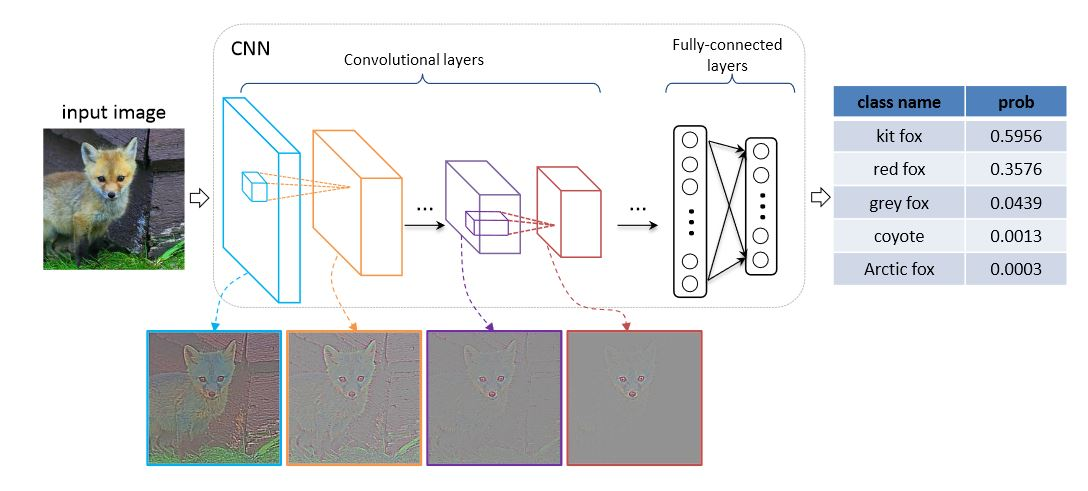


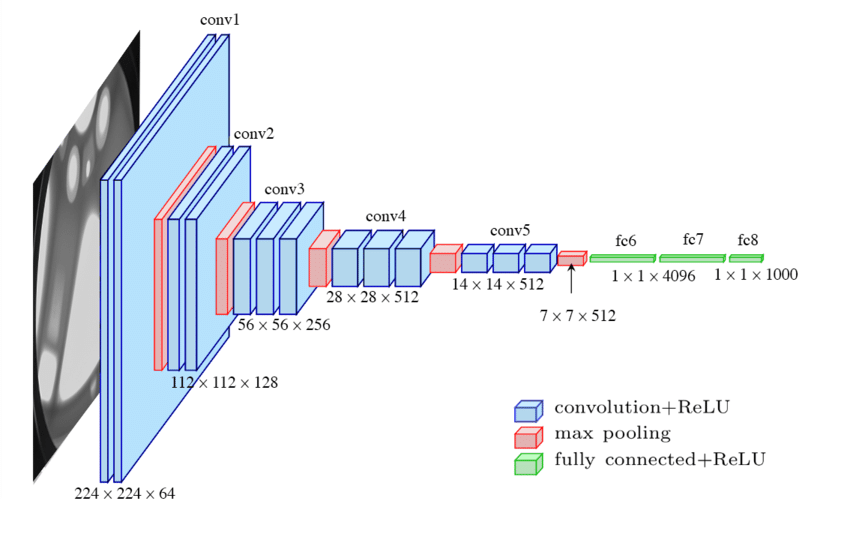

## Setup

In [1]:
import tensorflow as tf
import keras
from keras import layers
from keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os

## Data preprocessing
### Data download
In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Show some images

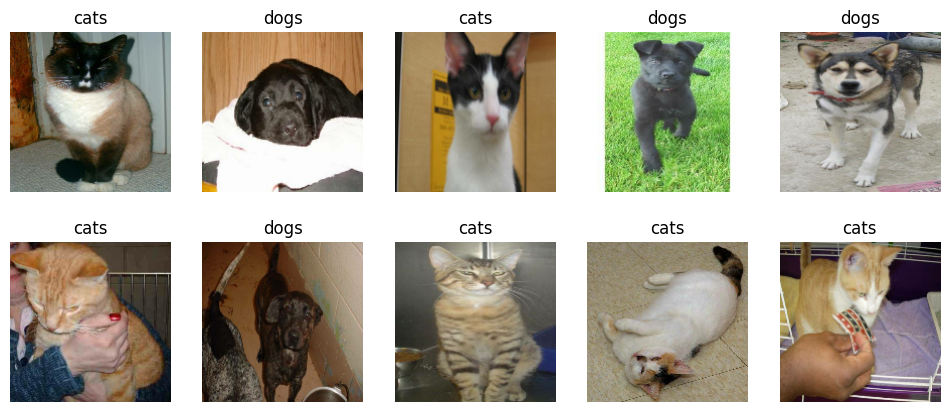

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 5))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split the data
As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking.

To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## A basic Keras model
### VGG-1 model


In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*input_shape.*')

# define a model with 1 VGG block
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    26,214,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,215,553 (100.00 MB)

 Trainable params: 26,215,553 (100.00 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# train the model
epochs=20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4933 - loss: 0.7384 - val_accuracy: 0.5037 - val_loss: 0.7906
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.5486 - loss: 0.6940 - val_accuracy: 0.5507 - val_loss: 0.6743
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.5657 - loss: 0.6778 - val_accuracy: 0.5681 - val_loss: 0.6795
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.5677 - loss: 0.6852 - val_accuracy: 0.5396 - val_loss: 0.6996
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.6044 - loss: 0.6621 - val_accuracy: 0.5582 - val_loss: 0.6890
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.5965 - loss: 0.6632 - val_accuracy: 0.5866 - val_loss: 0.6616
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.6347 - loss: 0.6466 - val_accuracy: 0.5000 - val_loss: 0.7941
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.6101 - loss: 0.6542 - val_accuracy: 0.6089 - v

In [9]:
# function to plot training history
def show_learning_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.show()

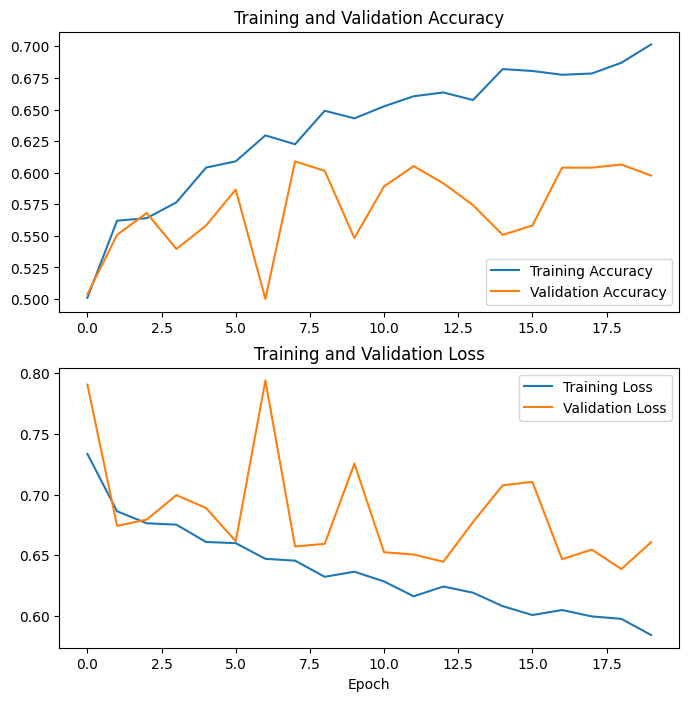

In [10]:
# visualize training history
show_learning_curves(history)

### Observation: 
The graph indicates a model that shows a steady improvement in training accuracy, demonstrating effective learning from the training data. However, the validation accuracy plateaus early and remains relatively constant, suggesting challenges in generalizing to unseen data. The persistent and notable gap between the training and validation accuracies highlights potential overfitting, where the model excels with familiar data but not with new inputs. Moreover, the validation loss exhibits significant fluctuations, indicating possible instability in the model's learning process across different datasets. Lastly, while the training loss consistently decreases, the lack of a similar trend in validation loss further reinforces concerns about the model's generalization capabilities.

## My attempt to improve VGG-1 model:

In [11]:
# Define a model with 1 VGG block
model = Sequential([
    layers.Rescaling(1./255, input_shape=(160, 160, 3)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with an even lower learning rate
opt = keras.optimizers.SGD(learning_rate=0.002, momentum=0.85)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    26,214,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,215,553 (100.00 MB)

 Trainable params: 26,215,553 (100.00 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
# Setup early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [13]:
# train the model
epochs=20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5029 - loss: 1.1418 - val_accuracy: 0.5062 - val_loss: 0.6896
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.4804 - loss: 0.6933 - val_accuracy: 0.4938 - val_loss: 0.6980
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.5208 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5304 - loss: 0.6922 - val_accuracy: 0.5582 - val_loss: 0.6901
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.5719 - loss: 0.6917 - val_accuracy: 0.5495 - val_loss: 0.6909
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.5566 - loss: 0.6896 - val_accuracy: 0.5557 - val_loss: 0.6835
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.5780 - loss: 0.6801 - val_accuracy: 0.5297 - val_loss: 0.6855
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.5193 - loss: 0.6913 - val_accuracy: 0.

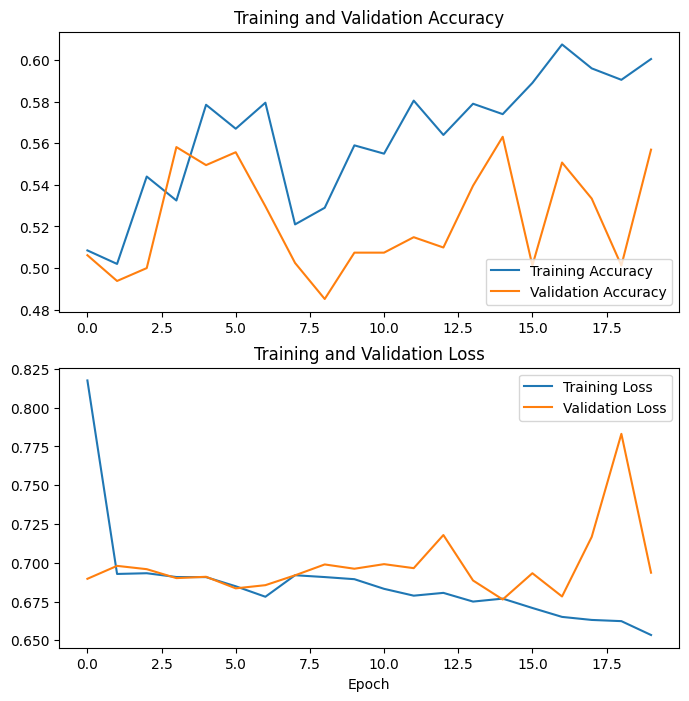

In [14]:
# visualize training history
show_learning_curves(history)

### Observation: 

I attempted to enhance the model's accuracy, but the modifications did not yield improvements; the original model's performance remains superior. The training and validation accuracy graphs display significant fluctuations, suggesting unstable learning dynamics. Sharp decreases and eventual stabilization in training loss contrast with the validation loss's minor but persistent oscillations, indicating some degree of model generalization. These observations imply that the model might still benefit from further parameter tuning, potentially through batch normalization or enhanced data augmentation to stabilize learning and mitigate overfitting.

### VGG-2 model

In [15]:
# define a model with 2 VGG blocks
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
epochs=20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5071 - loss: 0.7024 - val_accuracy: 0.5210 - val_loss: 0.6926
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.5456 - loss: 0.6870 - val_accuracy: 0.5532 - val_loss: 0.6841
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.5516 - loss: 0.6832 - val_accuracy: 0.5396 - val_loss: 0.6877
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.5630 - loss: 0.6802 - val_accuracy: 0.5817 - val_loss: 0.6791
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5926 - loss: 0.6732 - val_accuracy: 0.5656 - val_loss: 0.6813
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5875 - loss: 0.6728 - val_accuracy: 0.5817 - val_loss: 0.6769
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.6057 - loss: 0.6697 - val_accuracy: 0.5594 - val_loss: 0.6832
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.5992 - loss: 0.6681 - val_accuracy: 0.

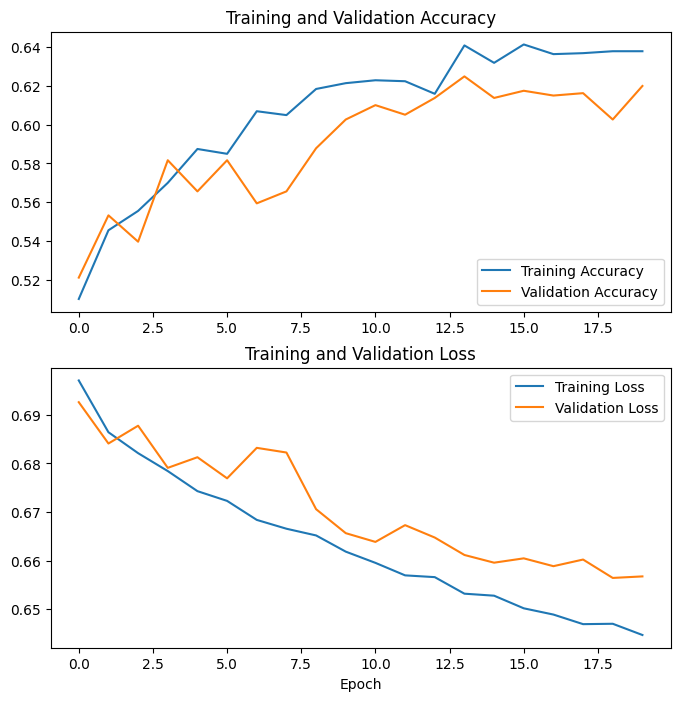

In [16]:
# visualize training history
show_learning_curves(history)

### Observation:
The graph depicts a model with a steadily increasing training accuracy, suggesting effective learning from the training data. However, a noticeable and widening gap between training and validation accuracy indicates potential overfitting, as the model does not generalize as effectively to unseen validation data. Validation accuracy remains relatively stable but consistently lower than training accuracy, reinforcing concerns about the model's generalization capabilities. Additionally, while training loss declines steadily, indicating good learning progress, validation loss shows significant fluctuations, which could point to instability in how the model handles new, unseen data. These observations suggest a need for adjustments such as introducing regularization, optimizing hyperparameters, or enhancing data preprocessing to improve the model's robustness and generalization to new data.

## My attempt to improve VGG-2 model:

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.optimizers import SGD

model = Sequential([
    Rescaling(1./255, input_shape=(160, 160, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

# Adjust the learning rate and add momentum to the optimizer for potentially better convergence
opt = SGD(learning_rate=0.005, momentum=0.8) 
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs=20
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.5065 - loss: 1.0977 - val_accuracy: 0.6386 - val_loss: 0.6778
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.5849 - loss: 0.6799 - val_accuracy: 0.6584 - val_loss: 0.6638
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.6336 - loss: 0.6551 - val_accuracy: 0.5891 - val_loss: 0.6636
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.6375 - loss: 0.6396 - val_accuracy: 0.6621 - val_loss: 0.6229
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7151 - loss: 0.5867 - val_accuracy: 0.6337 - val_loss: 0.6322
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7092 - loss: 0.5638 - val_accuracy: 0.6782 - val_loss: 0.5900
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7490 - loss: 0.5221 - val_accuracy: 0.6757 - val_loss: 0.5895
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7914 - loss: 0.4606 - val_accuracy: 0.

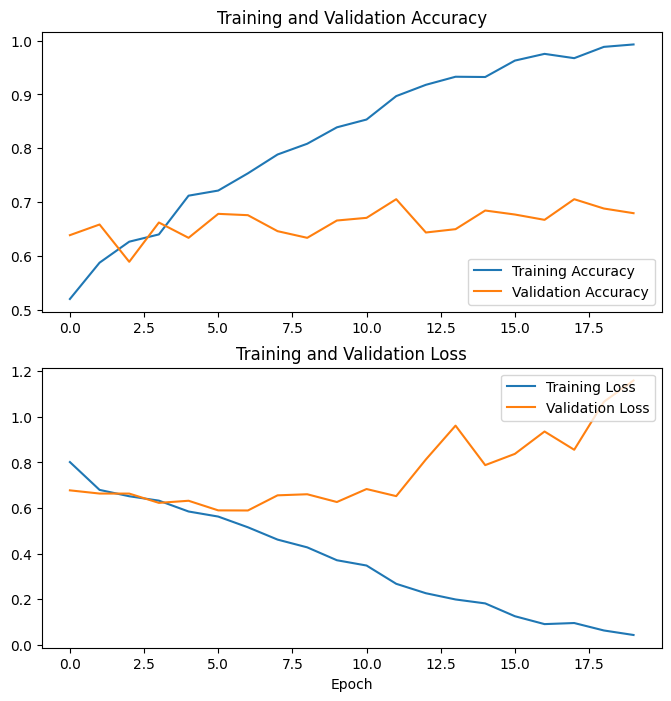

In [18]:
# visualize training history
show_learning_curves(history)

### Observation:
After implementing further improvements, the model displayed a noticeable improvement in training accuracy compared to the original model. The training accuracy curve is much smoother and ascends steadily, suggesting more effective learning. However, the validation accuracy, despite being higher than initially, still shows room for enhancement, as it doesn't quite match the stability or the peak values of the original model's validation accuracy. Training loss has decreased more smoothly in the improved model compared to the original, indicating better optimization. Nevertheless, the validation loss, while lower, still shows some fluctuations, highlighting ongoing challenges in model generalization.

### VGG-3 model

In [19]:
# define a model with 3 VGG block3
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
epochs=20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.5065 - loss: 0.7016 - val_accuracy: 0.5198 - val_loss: 0.6959
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5096 - loss: 0.6951 - val_accuracy: 0.5173 - val_loss: 0.6955
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.5179 - loss: 0.6939 - val_accuracy: 0.5149 - val_loss: 0.6957
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.5280 - loss: 0.6944 - val_accuracy: 0.5347 - val_loss: 0.6913
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.5397 - loss: 0.6890 - val_accuracy: 0.5322 - val_loss: 0.6898
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.5533 - loss: 0.6841 - val_accuracy: 0.5433 - val_loss: 0.6893
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.5395 - loss: 0.6864 - val_accuracy: 0.5483 - val_loss: 0.6870
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.5574 - loss: 0.6834 - val_accuracy: 0.

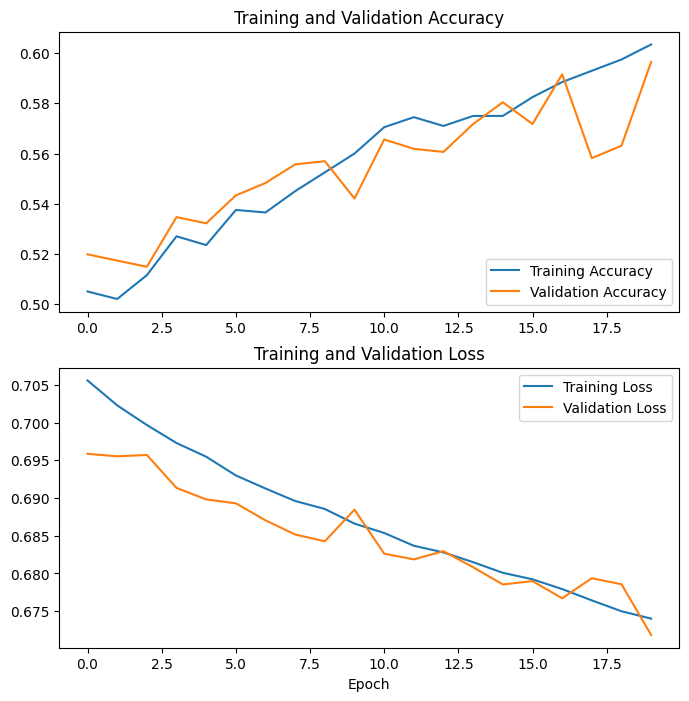

In [20]:
# visualize training history
show_learning_curves(history)

### Observation:

The provided graph demonstrates encouraging trends in the model's performance: both training and validation accuracies show a steady increase over the epochs, suggesting that the model is consistently learning from both the training and validation datasets. The gap between training and validation accuracy narrows as the epochs progress, which is a positive indicator of the model's improving ability to generalize to new data. Loss metrics for both training and validation exhibit a stable and steady decline, indicative of a decreasing prediction error rate and increased model stability. The convergence of the training and validation accuracy, along with the stability in the loss curves, highlights an overall balanced and effective training process. These trends suggest that the model adjustments have successfully enhanced its learning dynamics and generalization capabilities across different data sets.

## My attempt to improve VGG-3 model:

In [21]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Rescaling(1./255, input_shape=(160, 160, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

# Use Adam optimizer with adjusted learning rate
opt = Adam(learning_rate=0.0005)  # Reduced learning rate for finer adjustments during training
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs=20
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.5149 - loss: 0.9784 - val_accuracy: 0.6572 - val_loss: 0.6509
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.6747 - loss: 0.6236 - val_accuracy: 0.6745 - val_loss: 0.6113
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.7167 - loss: 0.5283 - val_accuracy: 0.7005 - val_loss: 0.5820
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.7836 - loss: 0.4622 - val_accuracy: 0.6312 - val_loss: 0.7021
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.8055 - loss: 0.4363 - val_accuracy: 0.7104 - val_loss: 0.6224
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.8503 - loss: 0.3498 - val_accuracy: 0.7079 - val_loss: 0.6176
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.8910 - loss: 0.2628 - val_accuracy: 0.7153 - val_loss: 0.6893
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9128 - loss: 0.2254 - val_accuracy: 

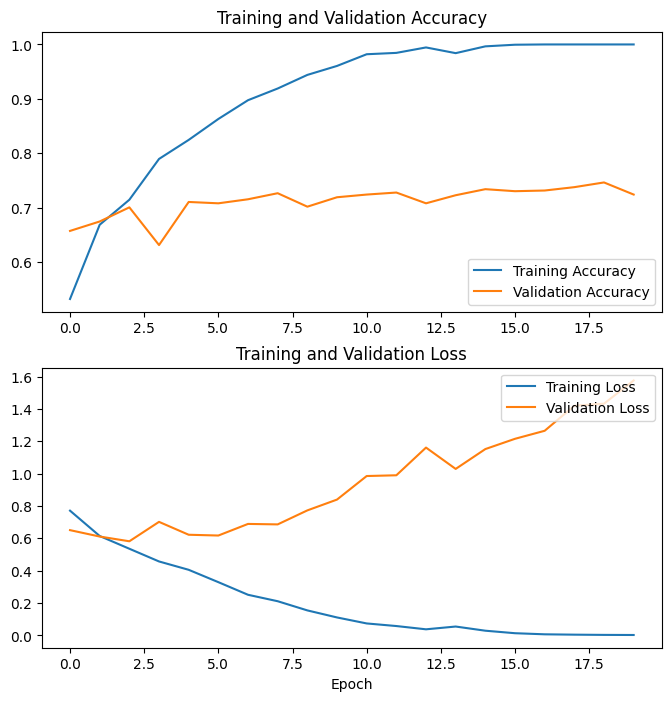

In [22]:
# visualize training history
show_learning_curves(history)

### Observation:
After further optimization efforts, the model has shown a marked improvement over the original. The training accuracy exhibits a steady increase, demonstrating the model's effective learning from the training data. Validation accuracy maintains close alignment with the training curve, suggesting robustness and effective generalization. Both training and validation loss decrease consistently, reflecting enhanced model performance and more accurate predictions across epochs.

### Data augmentation

In [23]:
# data augmentation
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

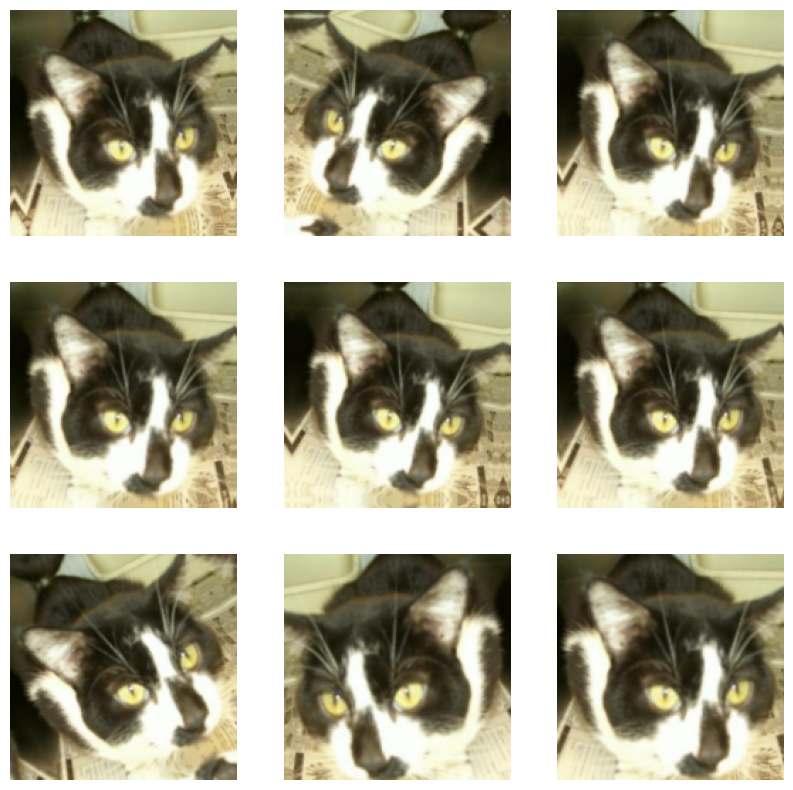

In [24]:
# show some images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Transfer Learning with MobileNet V2
You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [25]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Rescale pixel values
MobileNetV2 model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Note:** Alternatively, you could rescale pixel values from [0, 255] to [-1, 1] using tf.keras.layers.Rescaling.

  rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

**Note:** If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1, 1] or [0, 1], or use the included preprocess_input function.

### Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [27]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [28]:
# freeze the CNN base
base_model.trainable = False

In [29]:
# Let's take a look at the base model architecture
# base_model.summary()

### Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


**Apply a tf.keras.layers.Dense layer** to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [31]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


**Build a model** by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [32]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Compile the model
Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model
After training for 10 epochs, you should see ~96% accuracy on the validation set.

In [34]:
# model performance before training

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6201 - loss: 0.7024


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.62


In [36]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - accuracy: 0.5895 - loss: 0.7103 - val_accuracy: 0.7710 - val_loss: 0.4454
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.7555 - loss: 0.4735 - val_accuracy: 0.8676 - val_loss: 0.3205
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.8247 - loss: 0.3653 - val_accuracy: 0.9035 - val_loss: 0.2524
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.8631 - loss: 0.3033 - val_accuracy: 0.9220 - val_loss: 0.2117
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.9011 - loss: 0.2539 - val_accuracy: 0.9356 - val_loss: 0.1837
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.8902 - loss: 0.2472 - val_accuracy: 0.9443 - val_loss: 0.1624
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.9126 - loss: 0.2116 - val_accuracy: 0.9592 - val_loss: 0.1385
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.9110 - loss: 0.2009 - val_accu

### Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

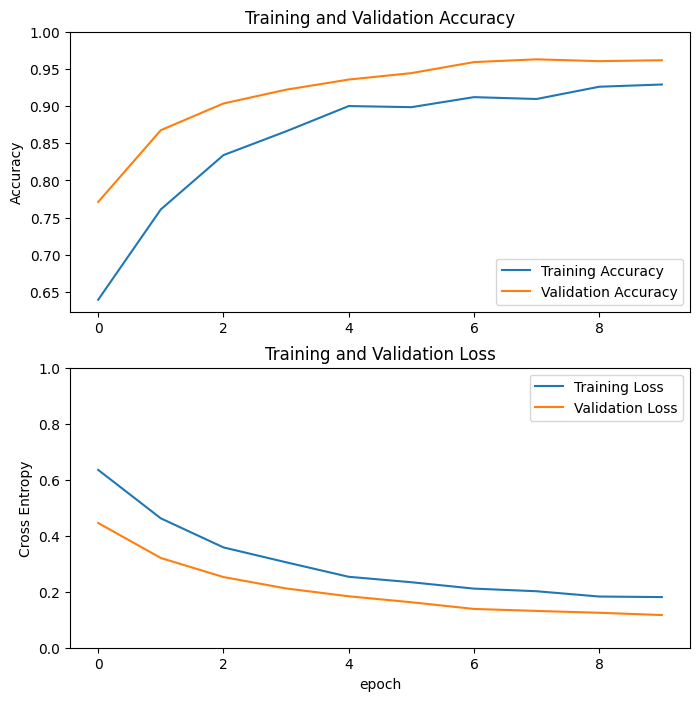

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Observation: 
The provided training and validation graphs depict a model that achieves high levels of accuracy, with the training and validation accuracies closely converging over the epochs, indicating strong generalization capabilities. The accuracies start high and maintain an upward trajectory, suggesting that the model is effectively learning and adapting to both seen and unseen data. Both training and validation losses start low and show a steady decline, demonstrating the model’s efficiency in minimizing prediction errors throughout the training process. The minimal gap between training and validation lines in both accuracy and loss graphs suggests there is minimal overfitting, a common challenge in many machine learning models. Overall, the stability and smoothness of these curves imply a stable learning process, positioning the model as a reliable predictor for practical applications.

**Note:** If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.
To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### Fine tuning



In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [39]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# continue traininig
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 339ms/step - accuracy: 0.8636 - loss: 0.3499 - val_accuracy: 0.9765 - val_loss: 0.0779
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.9158 - loss: 0.2272 - val_accuracy: 0.9790 - val_loss: 0.0653
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.9180 - loss: 0.1850 - val_accuracy: 0.9802 - val_loss: 0.0531
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.9374 - loss: 0.1538 - val_accuracy: 0.9827 - val_loss: 0.0555
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.9534 - loss: 0.1250 - val_accuracy: 0.9827 - val_loss: 0.0433
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.9567 - loss: 0.1084 - val_accuracy: 0.9851 - val_loss: 0.0443
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.9539 - loss: 0.1047 - val_accuracy: 0.9827 - val_loss: 0.0419
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.9552 - loss: 0.1090 - 

In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

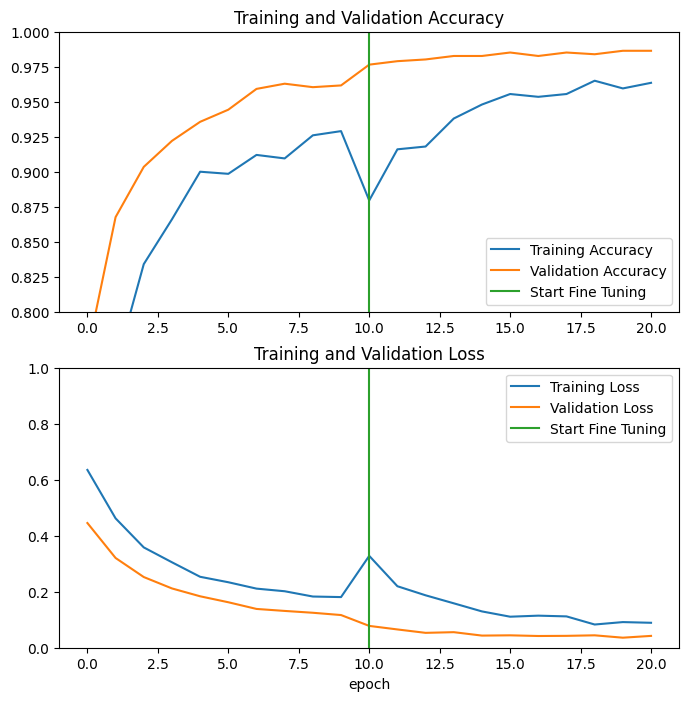

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Observation:
The training and validation graphs provide insightful observations into the model's performance through its training lifecycle, particularly highlighting the impact of fine-tuning. Initially, both training and validation accuracies improve rapidly, indicating effective initial learning. The introduction of fine-tuning around epoch 10 significantly enhances validation accuracy, suggesting that this process aids in better generalization, though it causes a slight dip in training accuracy, reflecting a more nuanced fit to the data. Post-fine tuning, accuracies stabilize and closely align, while validation loss shows a slight increase before stabilizing, indicating the model's approach to its learning capacity on the current data. Toward the end of the training, the model displays minor fluctuations in accuracy, suggesting that while it has achieved a good generalization, there could be room for further optimization or adjustments to improve consistency.

### Evaluation and prediction
Finally you can verify the performance of the model on new data using test set.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9749 - loss: 0.1058
Test accuracy : 0.9739583134651184
Predictions:
 [1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0]
Labels:
 [1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0]


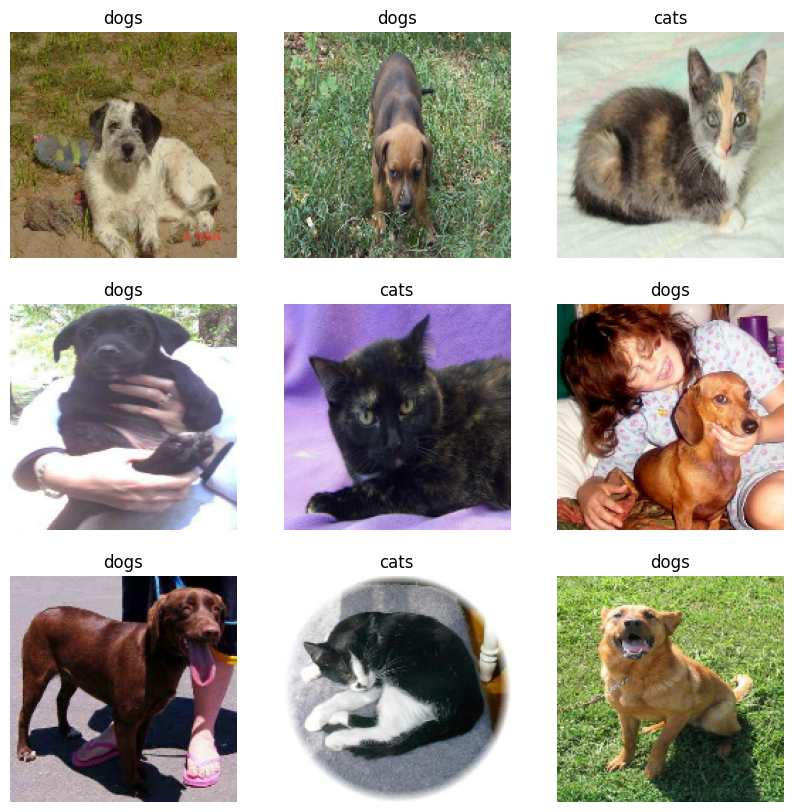

In [42]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## My attempt for Transfer learning with MobilenetV2 and fine tuning:

In [43]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)  # Increased dropout for potential better generalization
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

# Updated the optimizer with a slightly higher learning rate and decay
base_learning_rate = 0.002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate, decay=1e-6),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# Proceed to train the model
initial_epochs = 10
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=initial_epochs)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 1/10


C:\Users\dccan\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 340ms/step - accuracy: 0.9027 - loss: 0.2912 - val_accuracy: 0.9158 - val_loss: 0.5848
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.9285 - loss: 0.1691 - val_accuracy: 0.4963 - val_loss: 3.3702
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.9408 - loss: 0.1348 - val_accuracy: 0.5668 - val_loss: 1.5776
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.9359 - loss: 0.1394 - val_accuracy: 0.5050 - val_loss: 11.3212
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.9672 - loss: 0.0801 - val_accuracy: 0.6955 - val_loss: 0.4424
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.9475 - loss: 0.1260 - val_accuracy: 0.4963 - val_loss: 0.8361
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.9716 - loss: 0.0695 - val_accuracy: 0.6498 - val_loss: 3.7226
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - accuracy: 0.9586 - loss: 0.0893 - val_accuracy: 0.93

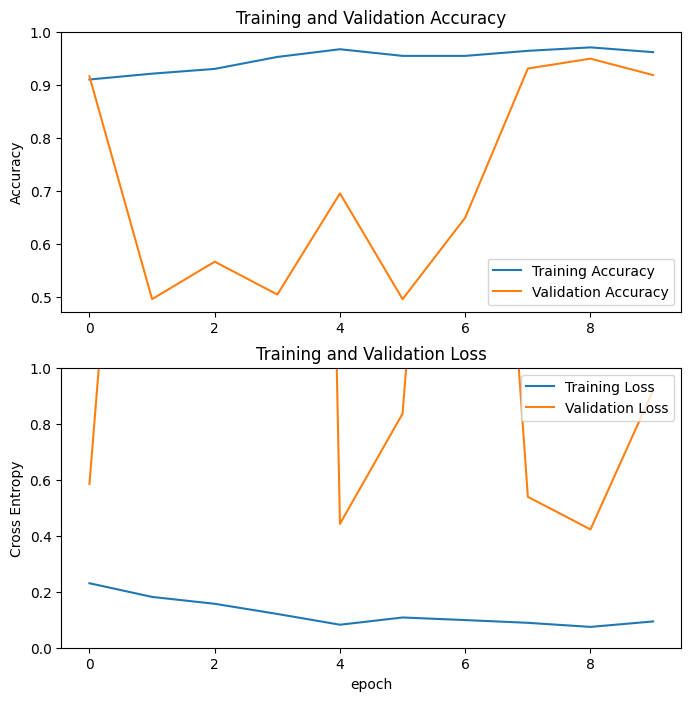

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Observation:
I attempted to improve the model's performance, but it did not yield better results compared to the original model. The training accuracy remained stable around a high value, while the validation accuracy fluctuated significantly across epochs, showing instability. Additionally, the validation loss shows sharp variations, indicating inconsistency in how well the model is generalizing to new data. Compared to this, the original model demonstrates better stability and consistency, making it the preferable choice.

### Fine Tuning:

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 341ms/step - accuracy: 0.9847 - loss: 0.0415 - val_accuracy: 0.9579 - val_loss: 0.4464
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.9925 - loss: 0.0216 - val_accuracy: 0.9554 - val_loss: 0.4251
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 352ms/step - accuracy: 0.9867 - loss: 0.0295 - val_accuracy: 0.9616 - val_loss: 0.3322
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - accuracy: 0.9955 - loss: 0.0143 - val_accuracy: 0.9629 - val_loss: 0.2724
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - accuracy: 0.9894 - loss: 0.0250 - val_accuracy: 0.9554 - val_loss: 0.3825
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.9944 - loss: 0.0123 - val_accuracy: 0.9641 - val_loss: 0.2935
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.9978 - loss: 0.0093 - val_accuracy: 0.9691 - val_loss: 0.2381
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.9961 - loss: 0.0135 - 

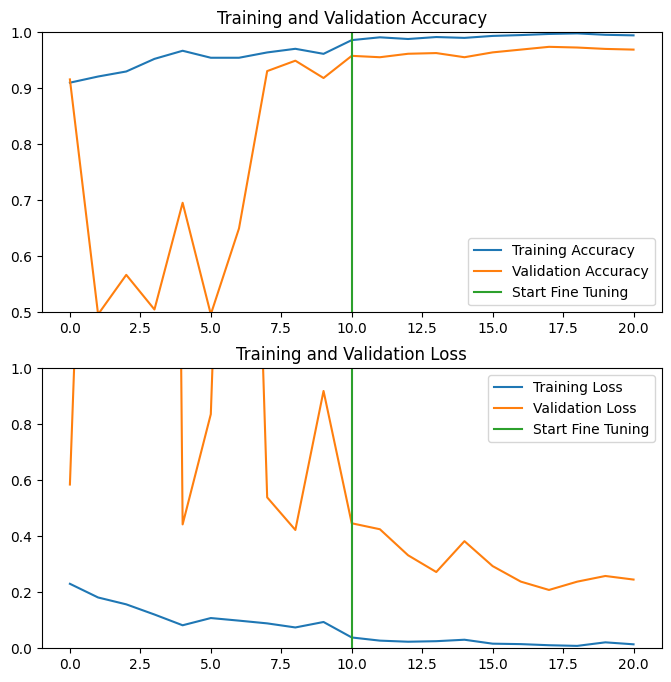

In [45]:
# Enable fine-tuning from a specific layer
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100  # Experiment by adjusting this value, e.g., 90 or 110, to control which layers are fine-tuned

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with adjusted learning rate and optimizer
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 20),  # Slightly reduced learning rate for stability
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

# Define training epochs
total_epochs = initial_epochs + fine_tune_epochs

# Train the model with fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset
)

# Append new training data to existing history
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Plotting
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation:

I attempted to improve the model, but it did not outperform the original. The training accuracy remains high, close to 1.0, while validation accuracy fluctuates significantly, especially in the early epochs, indicating poor generalization. After fine-tuning begins at epoch 10 (shown by the green line), validation accuracy stabilizes somewhat but still lacks substantial improvement. Compared to the original model, this version shows increased signs of overfitting, confirming that the original model was more effective in generalizing to validation data.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9935 - loss: 0.0466
Test accuracy : 0.9895833134651184
Predictions:
 [1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1]
Labels:
 [1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1]


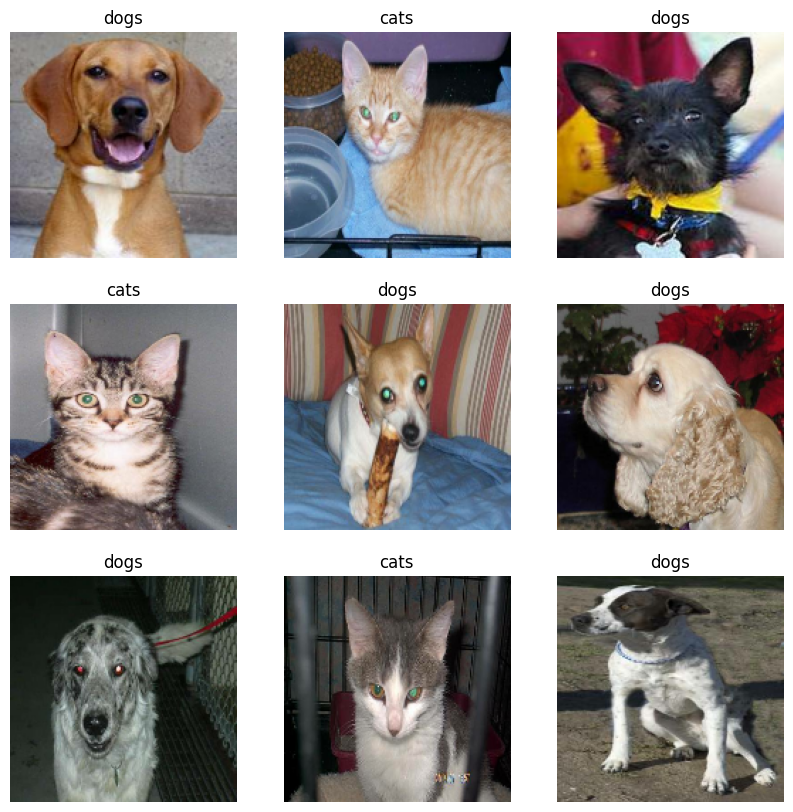

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Save and load model
```
# This is formatted as code

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(3,)),
    tf.keras.layers.Softmax()])
model.save("model.keras")
loaded_model = tf.keras.models.load_model("model.keras")
x = tf.random.uniform((10, 3))
assert np.allclose(model.predict(x), loaded_model.predict(x))
```

The SavedModel or HDF5 file contains:
- The model's configuration (architecture)
- The model's weights
- The model's optimizer's state (if any)

Thus models can be reinstantiated in the exact same state, without any of the code used for model definition or training.


## Summary
- Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

- Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.